In [1]:
from whstudy import WorldIndicators
from sklearn.manifold import TSNE
from ProjectionCorrelation import score_projections
from Orange.data.pandas_compat import table_from_frame
from Orange.data import ContinuousVariable
from Orange.preprocess import Normalize
import matplotlib.pyplot as plt

import random

### Get data from mongo database

In [19]:
handle = WorldIndicators('main', 'biolab')
country_codes = [code for code, _ in handle.countries()]
indicator_codes = ['EN.ATM.GHGT.KT.CE', 'EG.ELC.ACCS.ZS', 'AG.LND.FRST.ZS', 'GC.DOD.TOTL.GD.ZS',
                   'EN.POP.SLUM.UR.ZS', 'SL.UEM.TOTL.ZS', 'AG.YLD.CREL.KG', 'SH.STA.TRAF.P5',
                   'NE.EXP.GNFS.CD', 'NE.TRD.GNFS.ZS', 'SE.TER.ENRL.TC.ZS', 'SH.DTH.0509', 'SH.DYN.AIDS.ZS',
                   ]

df = handle.data(country_codes, indicator_codes, range(2000,2020))

### Split data to reference and overlay and perform t-SNE and scoring

In [42]:
cols_to_delete = df.columns[df.isnull().sum()/len(df) > .05]
df.drop(cols_to_delete, axis=1, inplace=True)
print(df)

     2004-EG.ELC.ACCS.ZS  2005-EG.ELC.ACCS.ZS  2006-EG.ELC.ACCS.ZS  \
USA           100.000000           100.000000           100.000000   
ABW           100.000000           100.000000           100.000000   
AND           100.000000           100.000000           100.000000   
AFE            26.176336            23.621498            27.299433   
CAN           100.000000           100.000000           100.000000   
..                   ...                  ...                  ...   
WSM            90.796112            91.508995            96.371730   
YEM            49.590000            54.987312            55.800335   
ZAF            80.900000            80.800000            80.700000   
ZWE            35.249660            35.572952            37.200000   
ZMB            20.300000            22.643414            23.292650   

     2007-EG.ELC.ACCS.ZS  2008-EG.ELC.ACCS.ZS  2009-EG.ELC.ACCS.ZS  \
USA           100.000000           100.000000           100.000000   
ABW           100.0

In [43]:
reference = df.iloc[:, :3].fillna(0)
overlay = df.iloc[:, 3:].fillna(0)

ref_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(reference.to_numpy())

tSNE_X = ContinuousVariable("t-SNE-x")
tSNE_Y = ContinuousVariable("t-SNE-y")

overlay_table = table_from_frame(overlay)
ref_table = table_from_frame(reference)
ref_table = ref_table.add_column(tSNE_X, ref_tsne[:, 0], to_metas=True)
ref_table = ref_table.add_column(tSNE_Y, ref_tsne[:, 1], to_metas=True)

scores = score_projections(ref_table, tSNE_X, tSNE_Y, overlay_table)


### Draw visualization of good and bad features

In [69]:
def plot_score(f_name, f_score, arr, title):
    vals = arr[:, f_name].X_df.to_numpy()
    plt.scatter(ref_tsne[:, 0], ref_tsne[:, 1], s=1 + 1000*vals, c=vals, cmap='plasma')

    plt.title(f"{title}:{f_score:.6f}")
    plt.xlabel("t-SNE-X", fontsize=10)
    plt.ylabel("t-SNE-Y", fontsize=10)
    plt.tick_params(axis="both", which='major', labelsize=9)
    plt.show()

def get_indicator_name(codes):
    descs = []
    indicators = handle.indicators()
    for code in codes:
        for (c, d, _, _) in indicators:
            if str(c) in str(code):
                descs.append(d)
    return descs

norm = Normalize(norm_type=Normalize.NormalizeBySpan, zero_based=True)
out = norm(overlay_table)

# Find best score and display

sorted_scores = sorted(scores, key=lambda tup: tup[1])

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [10, 7]


### Best scored features in overlay

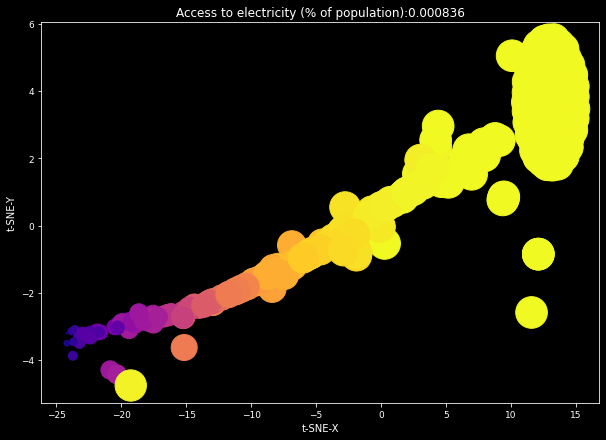

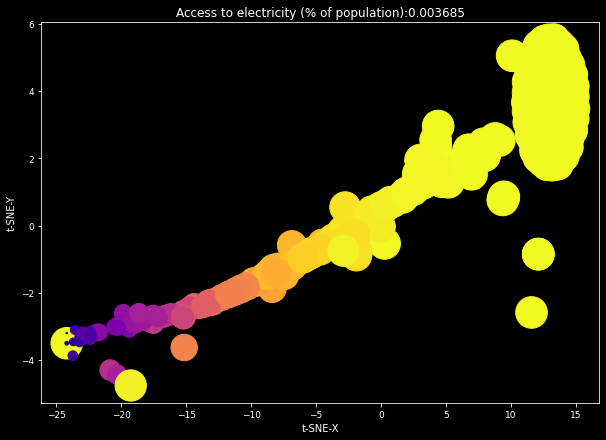

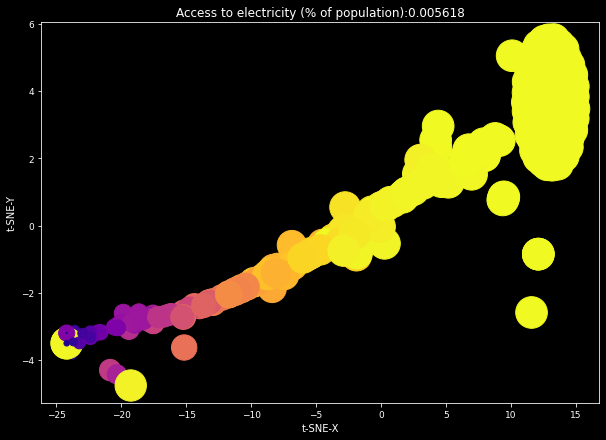

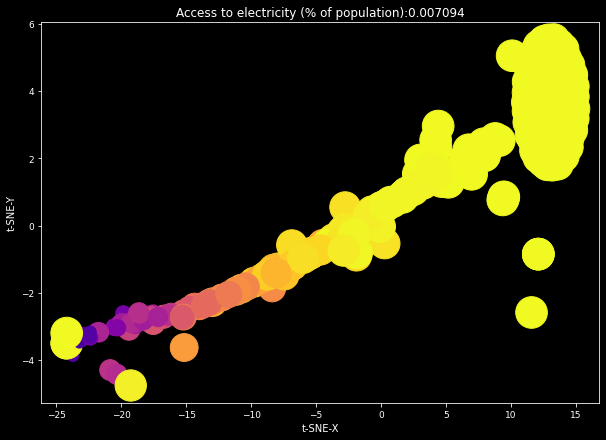

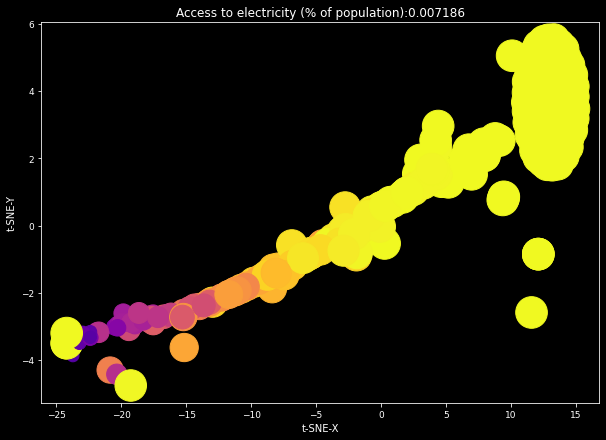

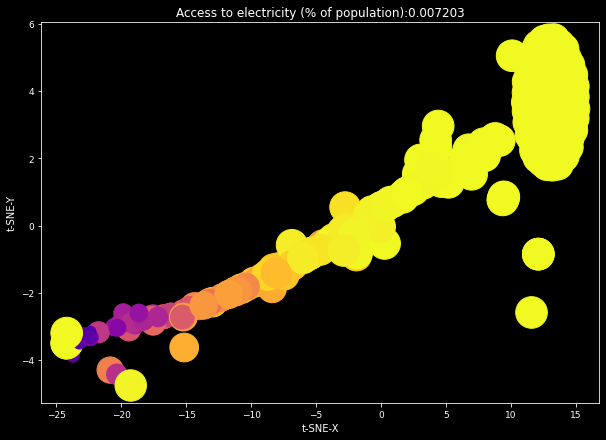

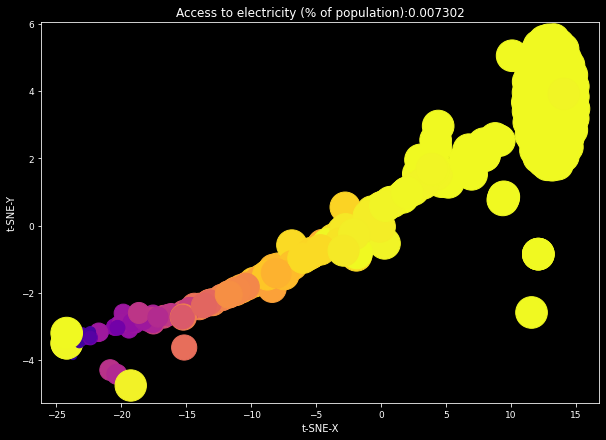

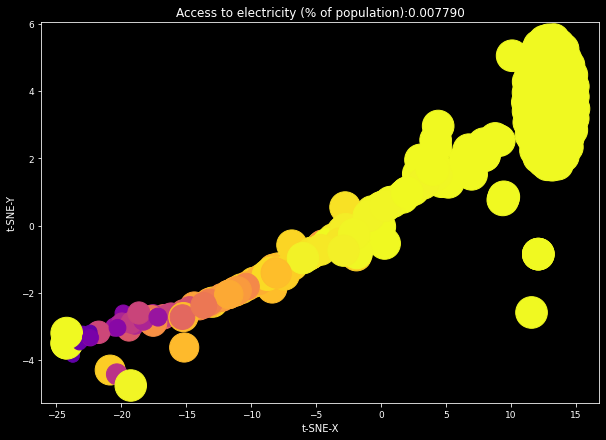

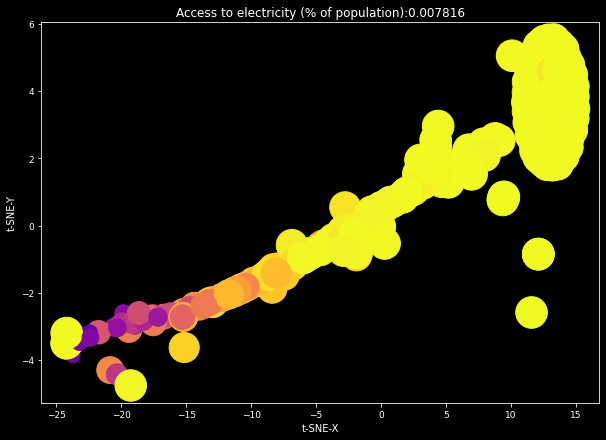

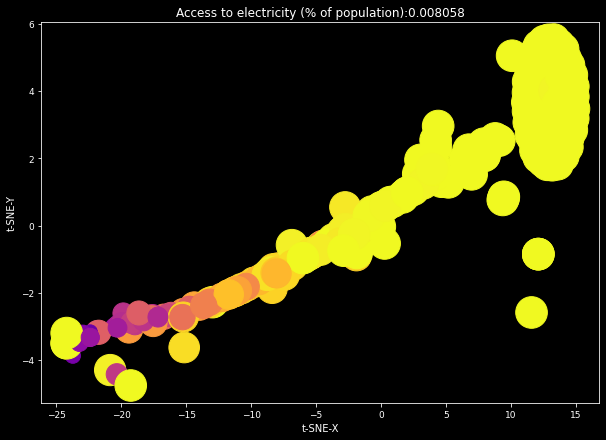

In [71]:
names = [n for (n, _) in sorted_scores]
descriptions = get_indicator_name(names)
ind = 0
for (name, score) in sorted_scores[:10]:
    plot_score(name, score, out, descriptions[ind])
    ind += 1

### Worst scored features in overlay

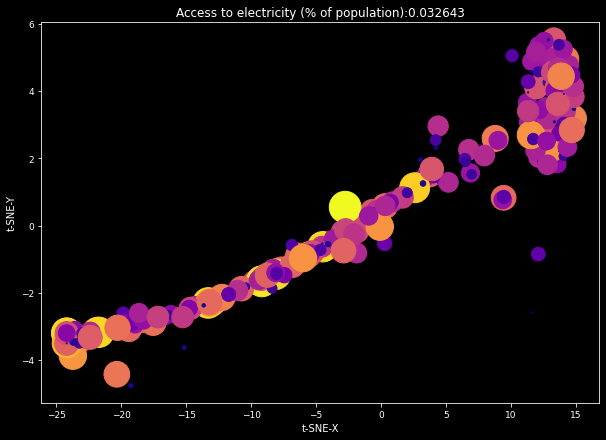

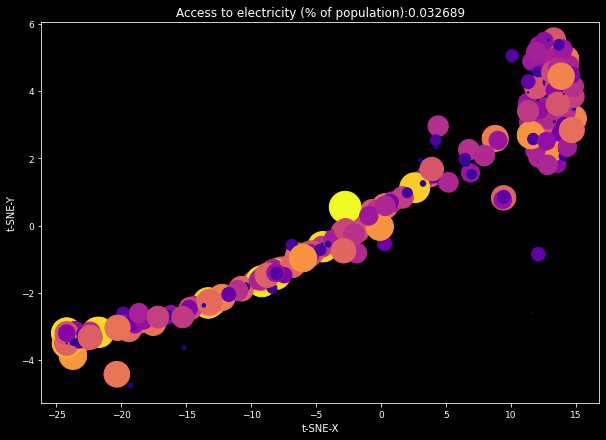

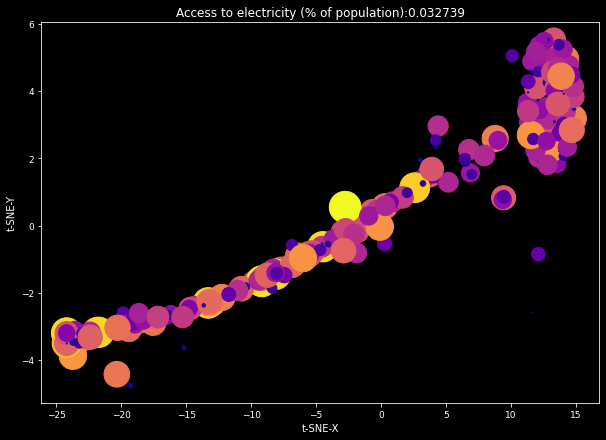

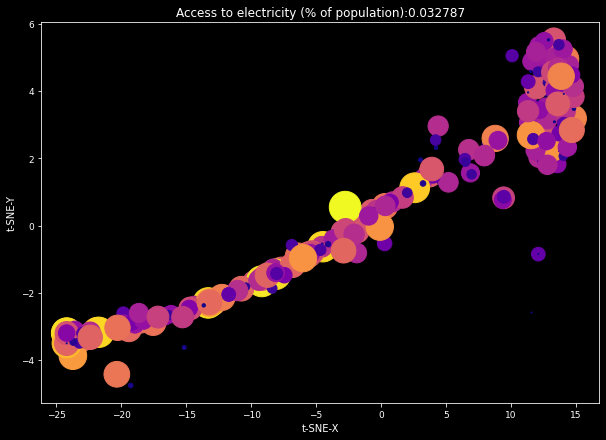

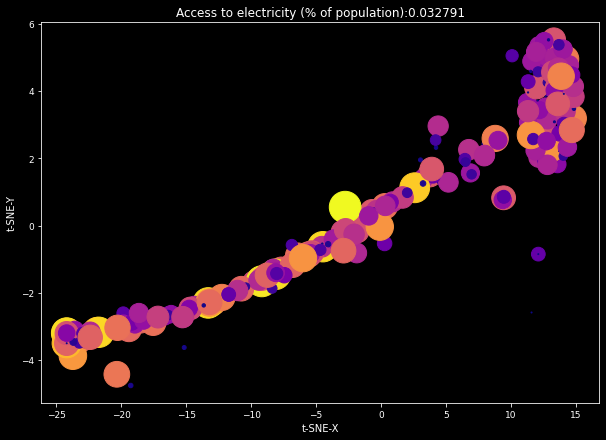

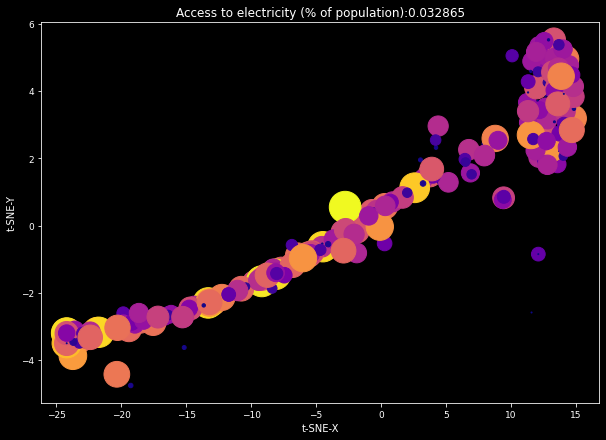

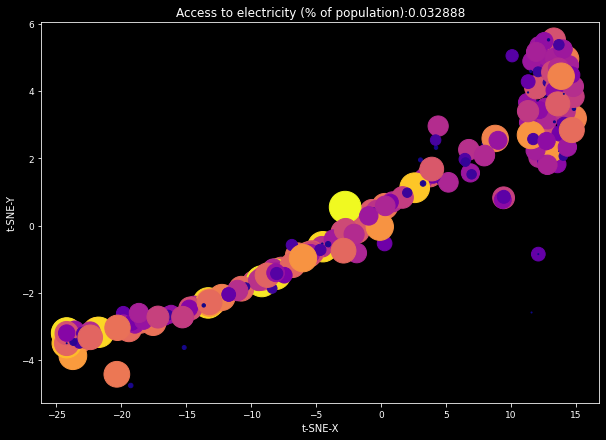

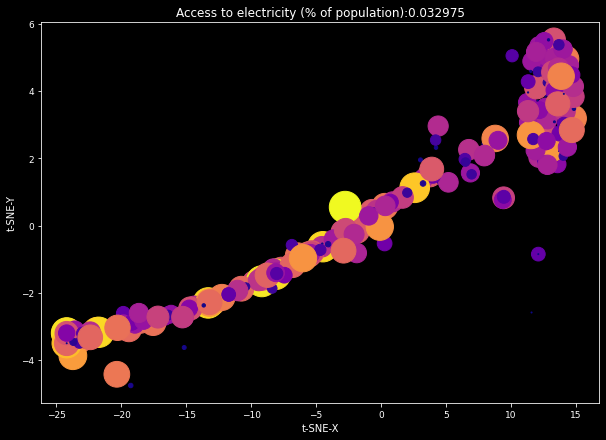

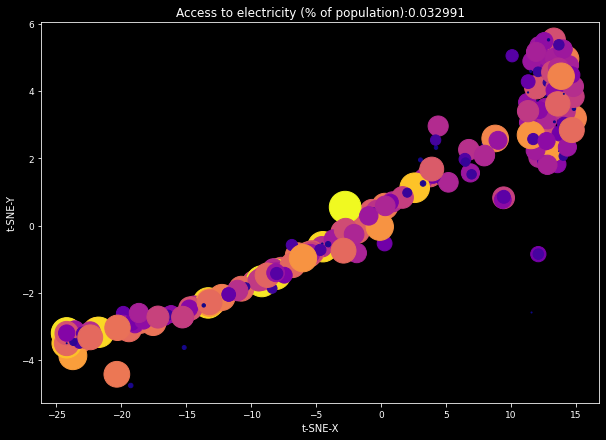

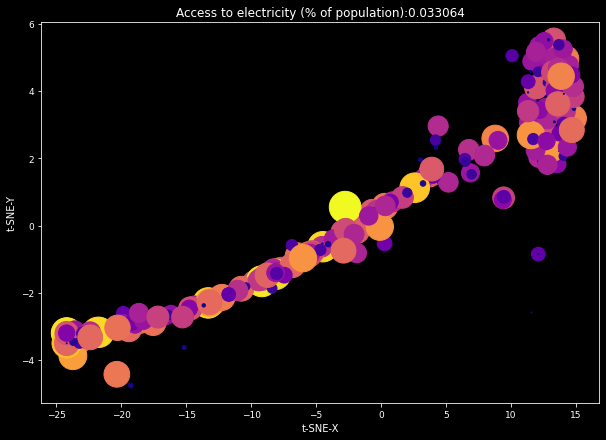

In [74]:
ind = 0
for (name, score) in sorted_scores[-10:]:
    plot_score(name, score, out, descriptions[ind])
    ind += 1